# Artificial data

  Weighted Lloyd Iteration 1: Weighted Inertia = 1937.70
  Weighted Lloyd Iteration 2: Weighted Inertia = 1453.66
  Weighted Lloyd Iteration 3: Weighted Inertia = 1252.64
  Weighted Lloyd Iteration 4: Weighted Inertia = 1248.66
  Weighted Lloyd Iteration 5: Weighted Inertia = 1248.66
  Weighted Lloyd Converged at iteration 5

--- Starting Main K-means|| Iterations ---
Main K-means|| Iteration 1: Inertia = 6243289.92
Main K-means|| Converged at iteration 1
Final Centroids Shape: (6, 50)
First 5 labels: [2 0 3 2 1]
Labels shape: (5000,)


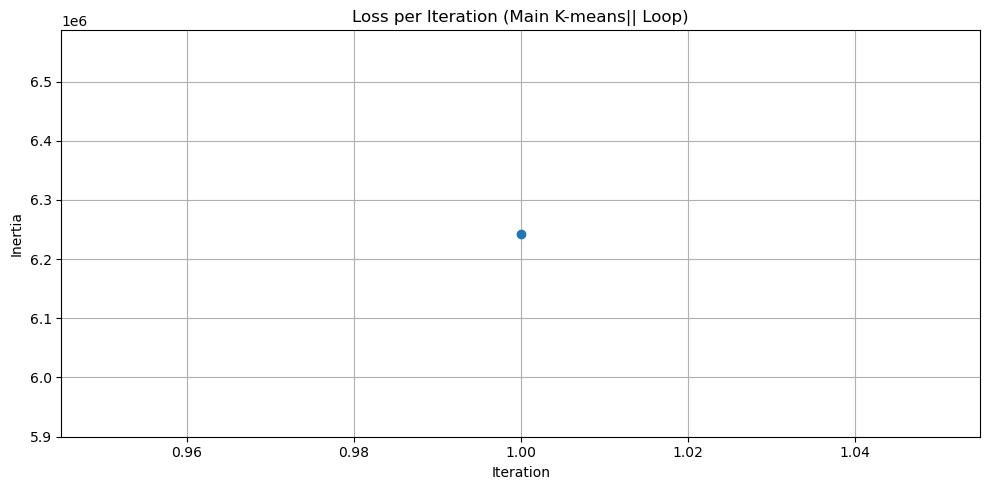

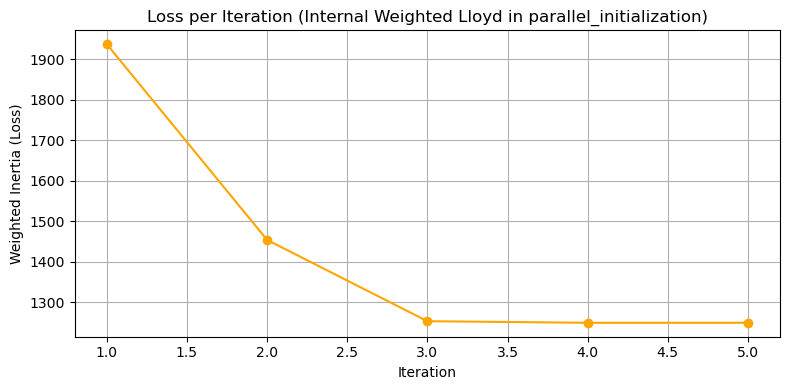

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin_min
from sklearn.datasets import make_blobs

def total_squared_distance(data, anchors):
    return pairwise_distances(data, anchors, metric='sqeuclidean').min(axis=1).sum()

def calculate_inertia(data, labels, centroids):
    inertia = 0.0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        if len(cluster_points) > 0:
            dists = np.linalg.norm(cluster_points - centroids[i], axis=1)
            inertia += np.sum(dists**2)
    return inertia

def calculate_weighted_inertia(data, labels, centroids, weights):
    inertia = 0.0
    for i in range(len(centroids)):
        cluster_points_indices = np.where(labels == i)[0]
        if len(cluster_points_indices) > 0:
            cluster_points = data[cluster_points_indices]
            cluster_weights = weights[cluster_points_indices]
            dists = np.linalg.norm(cluster_points - centroids[i], axis=1)
            inertia += np.sum(dists**2 * cluster_weights)
    return inertia

def parallel_initialization(data, num_clusters, oversampling_factor):
    n_samples, n_features = data.shape
    selected = np.random.choice(n_samples, size=1)
    centers = data[selected]

    dist_sum = total_squared_distance(data, centers)
    iterations = int(np.log(dist_sum)) if dist_sum > 0 else 0

    for _ in range(iterations):
        dists = pairwise_distances(data, centers, metric='sqeuclidean').min(axis=1)
        total = dists.sum()
        if total == 0:
            break

        prob = oversampling_factor * dists / total
        prob = prob / prob.sum()

        chosen_indices = np.random.choice(n_samples, size=len(prob), p=prob)
        unique_new = np.unique(chosen_indices)
        candidate_centers = data[unique_new]
        centers = np.vstack((centers, candidate_centers))

    d_matrix = pairwise_distances(data, centers, metric='euclidean')
    assigned = np.argmin(d_matrix, axis=1)

    center_weights = np.zeros(len(centers))
    cluster_sizes = np.bincount(assigned, minlength=len(centers))
    center_weights[:len(cluster_sizes)] = cluster_sizes

    norm_weights = center_weights / center_weights.sum() if center_weights.sum() != 0 else np.ones(len(centers)) / len(centers)

    final_labels, final_centroids, weighted_lloyd_history = run_weighted_lloyd(data=centers, weights=norm_weights, num_clusters=num_clusters, max_iters=10, tolerance=1e-8, verbose=True)
    return final_centroids, weighted_lloyd_history

def compute_weighted_means(points, groups, weights, num_groups):
    results = []
    for i in range(num_groups):
        group_data = points[groups == i]
        group_weights = weights[groups == i]
        if len(group_data) == 0:
            rand_idx = np.random.choice(len(points))
            results.append(points[rand_idx])
        else:
            weighted_avg = np.average(group_data, axis=0, weights=group_weights)
            results.append(weighted_avg)
    return np.stack(results)

def initialize_weighted_centers(data, weights, num_clusters):
    n_samples, _ = data.shape
    indices = np.random.choice(n_samples, size=1)
    centers = data[indices]

    for _ in range(1, num_clusters):
        dists = pairwise_distances(data, centers, metric='sqeuclidean').min(axis=1)
        probs = dists * weights
        probs = probs / probs.sum()
        idx = np.random.choice(n_samples, size=1, p=probs)
        new_center = data[idx]
        centers = np.vstack((centers, new_center))
    return centers

def run_weighted_lloyd(data, weights, num_clusters, max_iters=100, tolerance=1e-8, verbose=False):
    centers = initialize_weighted_centers(data, weights, num_clusters)
    weighted_lloyd_loss_history = []

    for i in range(max_iters):
        cluster_ids = assign_to_nearest(data, centers)
        updated = compute_weighted_means(data, cluster_ids, weights, num_clusters)

        if len(updated) != num_clusters:
            current_cluster_count = len(updated)
            if current_cluster_count < num_clusters:
                existing_cluster_indices = np.unique(cluster_ids)
                existing_centroids = updated

                temp_centers = np.empty((num_clusters, data.shape[1]))
                temp_centers[:current_cluster_count] = existing_centroids

                missing_clusters = num_clusters - current_cluster_count
                for j in range(missing_clusters):
                    rand_idx = np.random.choice(len(data))
                    temp_centers[current_cluster_count + j] = data[rand_idx]
                updated = temp_centers
            else:
                 pass

        current_inertia = calculate_weighted_inertia(data, cluster_ids, updated, weights)
        weighted_lloyd_loss_history.append(current_inertia)
        if verbose:
            print(f"  Weighted Lloyd Iteration {i + 1}: Weighted Inertia = {current_inertia:.2f}")

        if np.allclose(centers, updated, atol=tolerance):
            if verbose:
                print(f"  Weighted Lloyd Converged at iteration {i + 1}")
            break
        centers = updated

    return cluster_ids, centers, weighted_lloyd_loss_history

def assign_to_nearest(data, centers):
    return pairwise_distances_argmin_min(data, centers, metric='sqeuclidean')[0]

def recalculate_means(data, assignments, num_clusters):
    new_means = []
    for i in range(num_clusters):
        group = data[assignments == i]
        if len(group) > 0:
            new_means.append(group.mean(axis=0))
        else:
            random_point = data[np.random.randint(0, data.shape[0])]
            new_means.append(random_point)
    return np.stack(new_means)

def run_kmeans_parallel(data, k, max_steps=100, stop_tol=1e-8, oversample=2):
    initial_centroids, weighted_lloyd_history = parallel_initialization(data, k, oversample)
    main_loss_values = []

    print("\n--- Starting Main K-means|| Iterations ---")
    for i in range(max_steps):
        labels = assign_to_nearest(data, initial_centroids)
        updated_centroids = recalculate_means(data, labels, k)

        if len(updated_centroids) != k:
            current_cluster_count = len(updated_centroids)
            if current_cluster_count < k:
                temp_centroids = np.empty((k, data.shape[1]))
                temp_centroids[:current_cluster_count] = updated_centroids

                missing_clusters = k - current_cluster_count
                for j in range(missing_clusters):
                    rand_idx = np.random.choice(len(data))
                    temp_centroids[current_cluster_count + j] = data[rand_idx]
                updated_centroids = temp_centroids
            initial_centroids = updated_centroids
            continue

        inertia = calculate_inertia(data, labels, updated_centroids)
        main_loss_values.append(inertia)
        print(f"Main K-means|| Iteration {i + 1}: Inertia = {inertia:.2f}")

        if np.allclose(initial_centroids, updated_centroids, atol=stop_tol):
            print(f"Main K-means|| Converged at iteration {i + 1}")
            break

        initial_centroids = updated_centroids

    return labels, initial_centroids, main_loss_values, weighted_lloyd_history

samples = 5000
features = 50
k_clusters = 6

X_blob, ground_truth = make_blobs(n_samples=samples, n_features=features, centers=k_clusters, random_state=42)
X_blob, ground_truth = make_blobs(n_samples=samples, n_features=features, centers=k_clusters, random_state=42, cluster_std=5.0)
final_labels, final_centers, main_loss_values, weighted_lloyd_loss_values = run_kmeans_parallel(X_blob, k=k_clusters)

print("Final Centroids Shape:", final_centers.shape)
print("First 5 labels:", final_labels[:5])
print("Labels shape:", final_labels.shape)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(main_loss_values) + 1), main_loss_values, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Inertia")
plt.title("Loss per Iteration (Main K-means|| Loop)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(weighted_lloyd_loss_values) + 1), weighted_lloyd_loss_values, marker='o', linestyle='-', color='orange')
plt.xlabel("Iteration")
plt.ylabel("Weighted Inertia (Loss)")
plt.title("Loss per Iteration (Internal Weighted Lloyd in parallel_initialization)")
plt.grid(True)
plt.tight_layout()
plt.show()

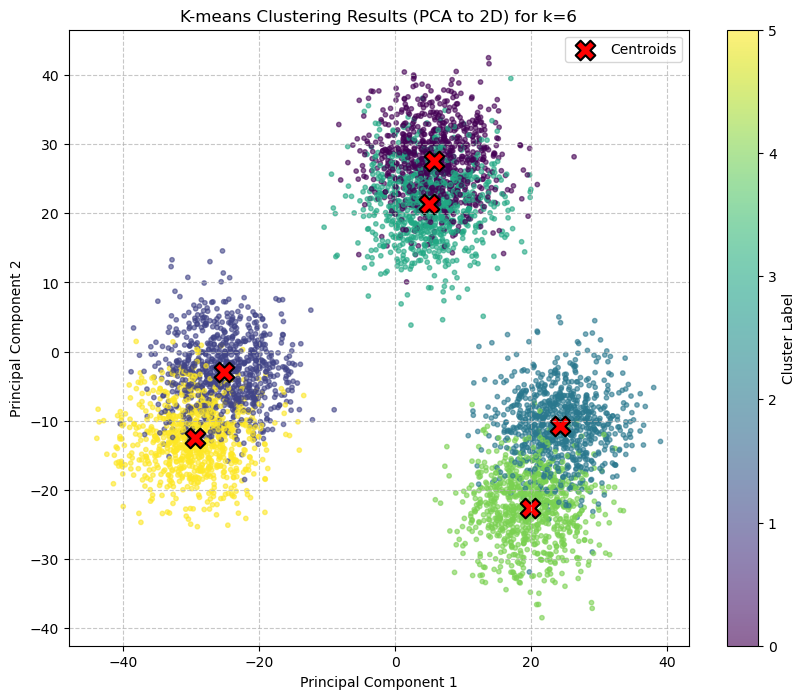

In [106]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#X_blob, ground_truth = make_blobs(n_samples=samples, n_features=features, centers=k_clusters, random_state=42, cluster_std=5.0) # Increase std for more overlap

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_blob)
reduced_centroids = pca.transform(final_centers)

plt.figure(figsize=(10, 8))

# Plot data points, colored by cluster
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=final_labels, cmap='viridis', s=10, alpha=0.6)

# Plot centroids
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1],
            marker='X', s=200, color='red', edgecolor='black', linewidth=1.5, label='Centroids')

plt.title(f'K-means Clustering Results (PCA to 2D) for k={k_clusters}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=range(k_clusters), label='Cluster Label')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# kddcup99 dataset

Fetching KDD Cup 1999 dataset (10% subset)... This may take a moment.
Successfully loaded 5000 records.

Categorical features (before one-hot encoding): ['duration', 'service', 'src_bytes', 'dst_bytes']
Numerical features: []

Original data shape: (5000, 4)
Processed data shape: (5000, 2809)

Starting K-means clustering with k=6...
  Weighted Lloyd Iteration 1: Weighted Inertia = 2.14
  Weighted Lloyd Iteration 2: Weighted Inertia = 2.14
  Weighted Lloyd Iteration 3: Weighted Inertia = 2.14
  Weighted Lloyd Converged at iteration 3

--- Starting Main K-means|| Iterations ---
Main K-means|| Iteration 1: Inertia = 10691.46
Main K-means|| Converged at iteration 1
K-means clustering completed in: 168.74 seconds
Final Centroids Shape: (6, 2809)
Labels shape: (5000,)
First 5 labels: [0 0 0 0 0]

Performing PCA for visualization...


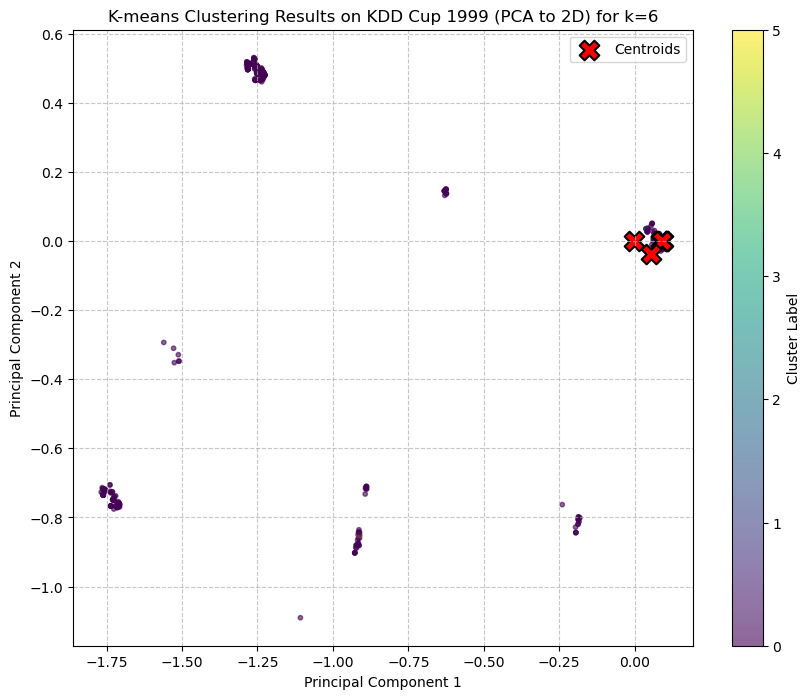

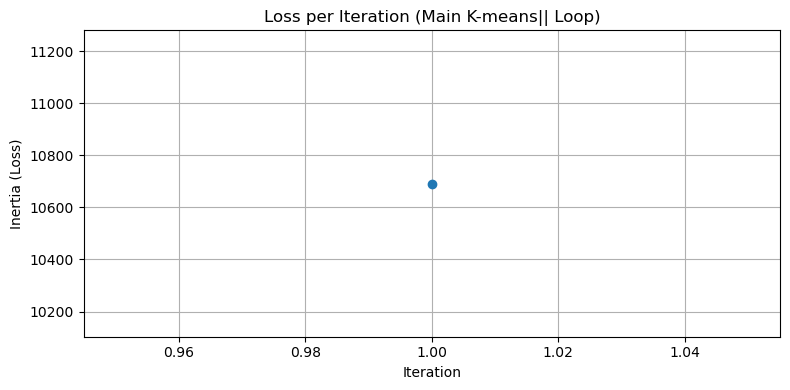

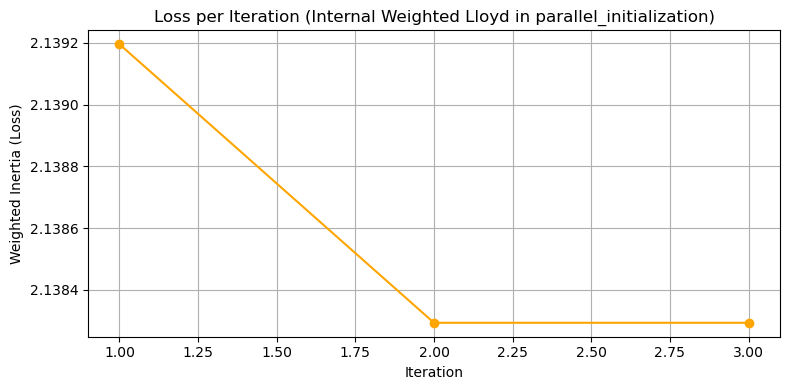

In [100]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin_min
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_kddcup99

import numpy as np
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin_min
from sklearn.datasets import make_blobs

def calculate_inertia(data, labels, centroids):
    inertia = 0.0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        if len(cluster_points) > 0:
            dists = np.linalg.norm(cluster_points - centroids[i], axis=1)
            inertia += np.sum(dists**2)
    return inertia

def calculate_weighted_inertia(data, labels, centroids, weights):
    inertia = 0.0
    for i in range(len(centroids)):
        cluster_points_indices = np.where(labels == i)[0]
        if len(cluster_points_indices) > 0:
            cluster_points = data[cluster_points_indices]
            cluster_weights = weights[cluster_points_indices]
            dists = np.linalg.norm(cluster_points - centroids[i], axis=1)
            inertia += np.sum(dists**2 * cluster_weights)
    return inertia

def total_squared_distance(data, anchors):
    return pairwise_distances(data, anchors, metric='sqeuclidean').min(axis=1).sum()

def parallel_initialization(data, num_clusters, oversampling_factor):
    n_samples, n_features = data.shape
    selected = np.random.choice(n_samples, size=1)
    centers = data[selected]

    dist_sum = total_squared_distance(data, centers)
    iterations = int(np.log(dist_sum)) if dist_sum > 0 else 0

    for _ in range(iterations):
        dists = pairwise_distances(data, centers, metric='sqeuclidean').min(axis=1)
        total = dists.sum()
        if total == 0:
            break

        prob = oversampling_factor * dists / total
        prob = prob / prob.sum()

        chosen_indices = np.random.choice(n_samples, size=len(prob), p=prob)
        unique_new = np.unique(chosen_indices)
        candidate_centers = data[unique_new]
        centers = np.vstack((centers, candidate_centers))

    d_matrix = pairwise_distances(data, centers, metric='euclidean')
    assigned = np.argmin(d_matrix, axis=1)

    center_weights = np.zeros(len(centers))
    cluster_sizes = np.bincount(assigned, minlength=len(centers))
    center_weights[:len(cluster_sizes)] = cluster_sizes

    norm_weights = center_weights / center_weights.sum() if center_weights.sum() != 0 else np.ones(len(centers)) / len(centers)

    final_labels, final_centroids, weighted_lloyd_history = run_weighted_lloyd(
        data=centers, weights=norm_weights, num_clusters=num_clusters, max_iters=10, tolerance=1e-8, verbose=True
    )
    return final_centroids, weighted_lloyd_history

def compute_weighted_means(points, groups, weights, num_groups):
    results = []
    for i in range(num_groups):
        group_data = points[groups == i]
        group_weights = weights[groups == i]
        if len(group_data) == 0:
            continue
        weighted_avg = np.average(group_data, axis=0, weights=group_weights)
        results.append(weighted_avg)
    return np.stack(results)

def initialize_weighted_centers(data, weights, num_clusters):
    n_samples, _ = data.shape
    indices = np.random.choice(n_samples, size=1)
    centers = data[indices]

    for _ in range(1, num_clusters):
        dists = pairwise_distances(data, centers, metric='sqeuclidean').min(axis=1)
        probs = dists * weights
        probs = probs / probs.sum()
        idx = np.random.choice(n_samples, size=1, p=probs)
        new_center = data[idx]
        centers = np.vstack((centers, new_center))
    return centers

def run_weighted_lloyd(data, weights, num_clusters, max_iters=100, tolerance=1e-8, verbose=False):
    centers = initialize_weighted_centers(data, weights, num_clusters)
    weighted_lloyd_loss_history = []

    for i in range(max_iters):
        cluster_ids = assign_to_nearest(data, centers)
        updated = compute_weighted_means(data, cluster_ids, weights, num_clusters)

        if len(updated) != num_clusters:
            current_cluster_count = len(updated)
            if current_cluster_count < num_clusters:
                existing_cluster_indices = np.unique(cluster_ids)
                existing_centroids = updated

                temp_centers = np.empty((num_clusters, data.shape[1]))
                temp_centers[:current_cluster_count] = existing_centroids

                missing_clusters = num_clusters - current_cluster_count
                for j in range(missing_clusters):
                    rand_idx = np.random.choice(len(data))
                    temp_centers[current_cluster_count + j] = data[rand_idx]
                updated = temp_centers
            else:
                 pass

        current_inertia = calculate_weighted_inertia(data, cluster_ids, updated, weights)
        weighted_lloyd_loss_history.append(current_inertia)
        if verbose:
            print(f"  Weighted Lloyd Iteration {i + 1}: Weighted Inertia = {current_inertia:.2f}")

        if np.allclose(centers, updated, atol=tolerance):
            if verbose:
                print(f"  Weighted Lloyd Converged at iteration {i + 1}")
            break
        centers = updated

    return cluster_ids, centers, weighted_lloyd_loss_history

def assign_to_nearest(data, centers):
    return pairwise_distances_argmin_min(data, centers, metric='sqeuclidean')[0]

def recalculate_means(data, assignments, num_clusters):
    new_means = []
    for i in range(num_clusters):
        group = data[assignments == i]
        if len(group) > 0:
            new_means.append(group.mean(axis=0))
    if not new_means:
        raise ValueError("No valid clusters to compute new centroids.")
    return np.stack(new_means)

def run_kmeans_parallel(data, k, max_steps=100, stop_tol=1e-8, oversample=2):
    initial_centroids, weighted_lloyd_history = parallel_initialization(data, k, oversample)
    loss_values = []

    print("\n--- Starting Main K-means|| Iterations ---")
    for i in range(max_steps):
        labels = assign_to_nearest(data, initial_centroids)
        updated_centroids = recalculate_means(data, labels, k)

        if len(updated_centroids) != k:
            current_cluster_count = len(updated_centroids)
            if current_cluster_count < k:
                temp_centroids = np.empty((k, data.shape[1]))
                temp_centroids[:current_cluster_count] = updated_centroids

                missing_clusters = k - current_cluster_count
                for j in range(missing_clusters):
                    rand_idx = np.random.choice(len(data))
                    temp_centroids[current_cluster_count + j] = data[rand_idx]
                updated_centroids = temp_centroids
            initial_centroids = updated_centroids
            continue

        inertia = calculate_inertia(data, labels, updated_centroids)
        loss_values.append(inertia)
        print(f"Main K-means|| Iteration {i + 1}: Inertia = {inertia:.2f}")

        if np.allclose(initial_centroids, updated_centroids, atol=stop_tol):
            print(f"Main K-means|| Converged at iteration {i + 1}")
            break

        initial_centroids = updated_centroids

    return labels, initial_centroids, loss_values, weighted_lloyd_history


print("Fetching KDD Cup 1999 dataset (10% subset)... This may take a moment.")
kdd_data = fetch_kddcup99(subset='SF', percent10=True, as_frame=True)

X_df = kdd_data.data[:5000]
y_true = kdd_data.target[:5000]

print(f"Successfully loaded {len(X_df)} records.")

categorical_features = X_df.select_dtypes(include=['object', 'category']).columns
numerical_features = X_df.select_dtypes(include=np.number).columns

print("\nCategorical features (before one-hot encoding):", categorical_features.tolist())
print("Numerical features:", numerical_features.tolist())

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_processed = pipeline.fit_transform(X_df).toarray()

print(f"\nOriginal data shape: {X_df.shape}")
print(f"Processed data shape: {X_processed.shape}")

X_processed = X_processed.astype(np.float64)

k_clusters = 6
print(f"\nStarting K-means clustering with k={k_clusters}...")

import time
start_time = time.time()
labels, centroids, main_loss_values, weighted_lloyd_loss_values = run_kmeans_parallel(X_processed, k=k_clusters)
end_time = time.time()

print(f"K-means clustering completed in: {end_time - start_time:.2f} seconds")
print("Final Centroids Shape:", centroids.shape)
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5])

print("\nPerforming PCA for visualization...")
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_processed)

if centroids.shape[0] == k_clusters:
    reduced_centroids = pca.transform(centroids)
else:
    print(f"Warning: Number of final centroids ({centroids.shape[0]}) does not match k ({k_clusters}). Adjusting plotting.")
    reduced_centroids = np.array([reduced_data[labels == i].mean(axis=0) for i in np.unique(labels) if np.sum(labels == i) > 0])
    k_clusters_actual = len(np.unique(labels))


plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1],
            marker='X', s=200, color='red', edgecolor='black', linewidth=1.5, label='Centroids')

plt.title(f'K-means Clustering Results on KDD Cup 1999 (PCA to 2D) for k={k_clusters}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=range(k_clusters), label='Cluster Label')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(main_loss_values) + 1), main_loss_values, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Inertia (Loss)")
plt.title("Loss per Iteration (Main K-means|| Loop)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(weighted_lloyd_loss_values) + 1), weighted_lloyd_loss_values, marker='o', linestyle='-', color='orange')
plt.xlabel("Iteration")
plt.ylabel("Weighted Inertia (Loss)")
plt.title("Loss per Iteration (Internal Weighted Lloyd in parallel_initialization)")
plt.grid(True)
plt.tight_layout()
plt.show()